In [1]:
# 1. Module Import
import numpy as np  # 1. 선형대수와 관련된 함수를 쉽게 이용할 수 있는 모듈 
import matplotlib.pyplot as plt  # 2. 함수 실행 결과 산출물에 대한 수치를 사람이쉽게 이해할 수 있도록 시각화 할 수 있는 외부 모듈
import torch  # 3. 우리가 이용하는 딥러닝 프레임워크 중 하나인 파이토치의 기본 모듈
import torch.nn as nn  # 4. pyTorch.Module 중 딥러닝 , 즉 인공 신경망 모델을 설계할 떄 필요한 함수를 모아 놓은 모듈
import torch.nn.functional as F  # 5. torch.nn 은  모듈 중에서도 자주 이용되는 함수를 F 로 지정
from torchvision import transforms, datasets  # 6. 컴퓨터 비전 연구 분야에서 자주 이용하는 'torchvision' 모듈 내 ' transforms', 'datasets'함수를 임포트

In [2]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA version:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")



Torch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
CUDA version: 12.6
CUDA available: True
GPU name: NVIDIA GeForce RTX 3070


In [3]:
# 딥러닝 모델을 설계할 때 활용하는 장비 확인 
if torch.cuda.is_available():
    DEVICE =torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:',torch.__version__ , 'Device:', DEVICE)

Using PyTorch version: 2.8.0+cu126 Device: cuda


In [4]:
# 하이퍼 파라미터 지정
BATCH_SIZE = 32  # MLP 학습시 Mini-Batch 1회(Iteration)당 사용되는 학습 데이터 수
EPOCHS = 10  # 전체 데이터를 이용해 학습을 진행한 횟수, ex) 전체 데이터 1만개, Mini_Batch 1개당 BATCH_SIZE 1000개 = Mini_Batch 10Iteration = 1 EPOCH 


In [5]:
# MNIST 데이터 다운로드 및 DataLoader 구성 (Train/Test 세트 분리)

# 1. 학습용 데이터셋 다운로드
train_dataset = datasets.MNIST(
    root="./data/MNIST",               # 데이터를 저장할 디렉토리 경로
    train=True,                        # 학습용 데이터 지정
    download=True,                     # 데이터가 없으면 인터넷에서 자동 다운로드
    transform=transforms.ToTensor()    # 이미지를 Tensor로 변환 (0~1 범위로 정규화됨)
)

# 2. 테스트용 데이터셋 다운로드
test_dataset = datasets.MNIST(
    root="./data/MNIST",               # 동일한 저장 경로
    train=False,                       # 테스트용 데이터 지정
    transform=transforms.ToTensor()    # 이미지 Tensor 변환 및 정규화
)

# 3. 학습용 데이터 로더 설정
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,             # 학습 데이터셋 지정
    batch_size=BATCH_SIZE,             # 한 번에 불러올 데이터 수
    shuffle=True                       # 매 epoch마다 데이터를 섞어서 학습 (일반적으로 True로 설정)
)

# 4. 테스트용 데이터 로더 설정
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,              # 테스트 데이터셋 지정
    batch_size=BATCH_SIZE,             # 테스트 시에도 동일한 배치 크기 사용
    shuffle=False                      # 테스트 데이터는 순서를 유지 (일반적으로 False)
)


In [6]:
# 4. 데이터 확인하기(1)
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(),'type:',x_train.type())   # 32개의 이미지 데이터 = Mini-Batch 1개 구성  = 한 개의 이미지는 가로 28개, 세로 28개의 픽셀, 채널 1개인 흑백 이미지 데이터
    print('y_train:', y_train.size(),'type:',y_train.type())   # 32개의 이미지 데이터 각각의 대한 라벨링 데이터  
    break


x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


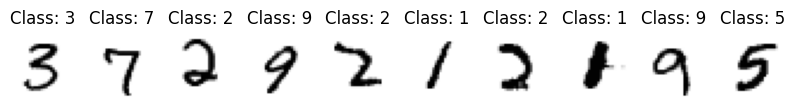

In [7]:
# 5. 데이터 확인하기(2) 
pltsize = 1 
plt.figure(figsize=(10 * pltsize,pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap ='grey_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
# 6. MLP(Multi Layer Perception) 모델 설계하기

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [9]:
# 다층 퍼셉트론(MLP) 모델 정의
class Net(nn.Module):  # nn.module → nn.Module (클래스명은 대문자로 시작해야 함)
    def __init__(self):
        super(Net, self).__init__() 
        
        # 첫 번째 완전 연결층 (입력: 28x28 픽셀 → 출력: 512 노드)
        self.fc1 = nn.Linear(28*28, 512)  

        # 두 번째 완전 연결층 (입력: 512 노드 → 출력: 256 노드)
        self.fc2 = nn.Linear(512, 256)

        # 세 번째 완전 연결층 (입력: 256 노드 → 출력: 10 클래스)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        # 이미지를 1차원 벡터로 변환 (배치 크기, 784)
        x = x.view(-1, 28*28)

        # 첫 번째 층 + sigmoid 활성화 함수
        x = self.fc1(x)
        x = F.sigmoid(x)  # 최근에는 ReLU를 더 많이 사용함

        # 두 번째 층 + sigmoid 활성화 함수
        x = self.fc2(x)
        x = F.sigmoid(x)

        # 세 번째 층 + log_softmax 활성화 함수 (출력: 확률 로그값)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x


In [10]:
# 7. Optimizer, Objective Function 설정 
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
# 8. MLP 모델 학습을 진행하면서 학습 데이터에 대한 모델 성능을 확인하는 함수 정의하기 
def train(model, train_loader, optimizer, log_interval,Ephoc):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Ephoc,batch_idx*len(image),len(train_loader.dataset), 100. * batch_idx / len(train_loader),loss.item()))
           

In [12]:
def train(model, train_loader, optimizer, log_interval,Epoch):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {Epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tTrain Loss: {loss.item():.6f}")
     

In [ ]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의하기 
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0 
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy =100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy            